In [1]:
from spectrum import arma2psd, arburg
from pyecharts import Line, Kline, Bar, Overlap, Grid, Scatter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
#二阶导为0，拐点
def inflexion_point(psd):
    for i in range(2,len(psd)-2):
        k1 = psd[i-2] - psd[i-1]
        k2 = psd[i-1] - psd[i]
        k3 = psd[i] - psd[i+1]
        k4 = psd[i+1] - psd[i+2]
        if (k1-k2) *(k3-k4) < 0:
            break
    return i

In [3]:
#一阶导为0，驻点
def stationary_point(psd):
    for i in range(1,len(psd)-1):
        k1 = psd[i-1] - psd[i]
        k2 = psd[i] - psd[i+1]
        if k1*k2 < 0:
            break
    return i

In [4]:
# 每个psd曲线对应的峰值乘上相应的频率
def peakMul(psd):
    n = 0
    for i in range(1,len(psd)-1):
        k1 = psd[i]-psd[i-1]
        k2 = psd[i]-psd[i+1]
        if k1 > 0 and k2 >0:
            n += psd[i]*i
    return n/1000
def bottomNum(psd):
    m = 0
    for i in range(1,len(psd)-1):
        k1 = psd[i]-psd[i-1]
        k2 = psd[i]-psd[i+1]
        if k1 > 0 and k2 >0:
            m += 1
    return m    

In [5]:
pwd = os.getcwd()
data_raw = pd.read_csv(os.path.join(pwd, "csg_000300_15m.csv"), encoding="gb2312")
data_raw = data_raw.drop(np.where((data_raw["volume"] == 0) | (data_raw["close"] == 0))[0])
data = data_raw["close"].values.copy()[-4000:]
#data = data_raw.iloc[200:,1].ravel()
data

array([ 3369.906,  3368.14 ,  3371.204, ...,  4223.501,  4226.519,
        4225.001])

In [12]:
def burgPeak(data,N=40,order=8,threshold=2,interval=10):
    l = len(data)
    peak = np.zeros(N - 1).tolist()

    for i in range(l - N + 1):
        x = data[i:(i + N)]
        AR, rho, ref = arburg(x, order)
        PSD = arma2psd(AR, rho=rho, NFFT=512)
        PSD = PSD[len(PSD):len(PSD) // 2:-1]
        PSD = (10 * np.log10(abs(PSD) * 2. / (2. * np.pi))).tolist()
        n = peakMul(PSD)
        peak.append(n)  # 认为这个频率就是对应该时点最大的频率

    shock = [i for i,x in enumerate(peak) if x <threshold]
    return shock,peak

<IPython.core.display.Javascript object>


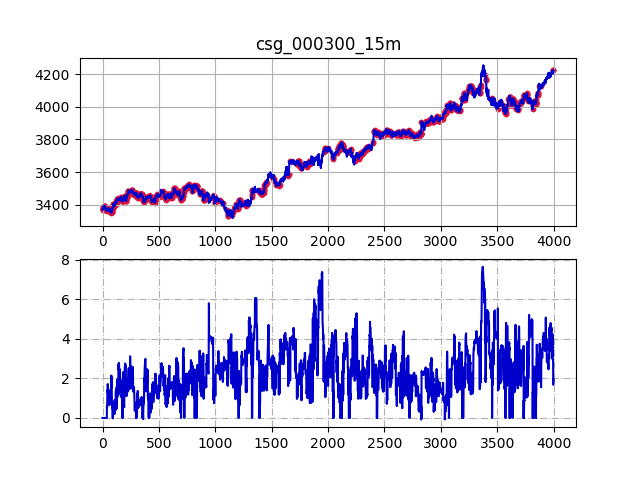

In [13]:
# 以沪深300 15分钟收盘价作为识别对象，标红的点是震荡点
%matplotlib notebook
shock,peak = burgPeak(data)
plt.subplot(2,1,1)
plt.scatter(shock,data[shock],s = 10,c='#DC143C',marker='o')
plt.plot(data,c='#0000CD')
plt.grid(True)
plt.title('csg_000300_15m')
plt.subplot(2,1,2)
plt.plot(peak,c='#0000CD')
plt.grid(True, linestyle = "-.")
plt.show()
# 一些长时间上涨或者下跌的时期保留下来，作为可交易点，大部分震荡点被过滤
# 具体收益效果有待验证


In [11]:
len(shock)


1066

In [5]:
def displayC(data,trend_points,shock_points,fre):
    index = np.arange(len(fre))
    line = Line()
    line.add("close", index, data,is_datazoom_show=True, datazoom_type="both",yaxis_min=3600, yaxis_max="dataMax",
             datazoom_xaxis_index=[0,1], is_more_utils=True,tooltip_tragger="axis", tooltip_axispointer_type='cross')

    scatter = Scatter()
    scatter.add("trend_points", trend_points, data[trend_points], is_datazoom_show=True, datazoom_type="both", symbol_size=7)

    overlap = Overlap()
    overlap.add(line)
    overlap.add(scatter)
    f_line = Line()
    f_line.add("frequency", index, fre,is_datazoom_show=True, datazoom_type="both", legend_top = "50%")
    
    grid = Grid(width= 1000, height=800)
    grid.add(overlap, grid_bottom="55%")
    grid.add(f_line, grid_top="55%")
    
def displayS(data,trend_points,shock_points,fre):
    plt.subplot(2,1,1)
    plt.scatter(trend_points,data[trend_points],s = 10,c='#DC143C',marker='o')
    plt.plot(data,c='#0000CD')
    plt.grid(True)
    plt.title('close price - time(ZZ500 30m)')
    plt.subplot(2,1,2)
    plt.plot(fre,c='#0000CD')
    plt.title('frequency - time')
    plt.show()

In [15]:
#input 除0，nan，是个array
def burgSimple(data,N=40,order=8,threshold=100,interval=10):
    l = len(data)
    fre = np.zeros(N - 1).tolist()

    for i in range(l - N + 1):
        x = data[i:(i + N)]
        AR, rho, ref = arburg(x, order)
        PSD = arma2psd(AR, rho=rho, NFFT=512)
        PSD = PSD[len(PSD):len(PSD) // 2:-1]
        PSD = (10 * np.log10(abs(PSD) * 2. / (2. * np.pi))).tolist()
        #PSD = np.where(PSD < 0, 0, PSD).tolist()
        PSD = PSD[threshold:]
        index = PSD.index(max(PSD)) + threshold
        fre.append(index)  # 认为这个频率就是对应该时点最大的频率

    fre = np.array(fre)
    trend_points = [i for i,x in enumerate(fre) if x <= threshold+interval]
    shock_points = np.where(fre > threshold+interval)[0]
    return trend_points,shock_points,fre

<IPython.core.display.Javascript object>


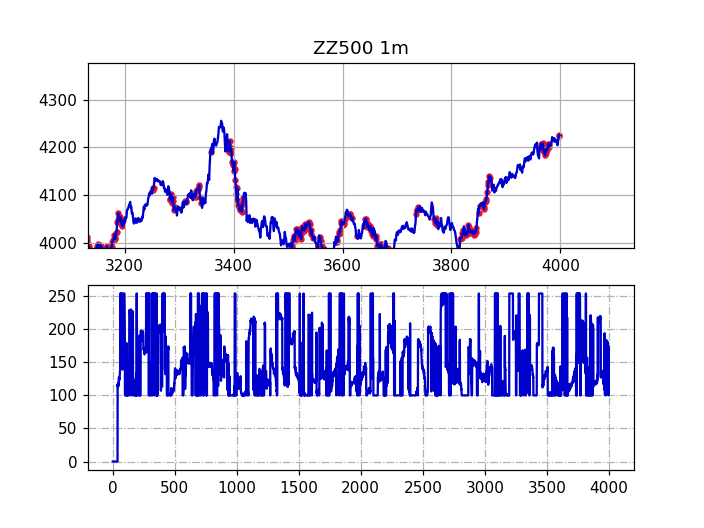

In [16]:
# 用最大psd对应fre返回，以一个threshod截取挑选的点为trend，效果不是很好
%matplotlib notebook
trend_points,shock_points,fre = burgSimple(data)
plt.subplot(2,1,1)
plt.scatter(trend_points,data[trend_points],s = 10,c='#DC143C',marker='o')
plt.plot(data,c='#0000CD')
plt.grid(True)
plt.title('ZZ500 1m')
plt.subplot(2,1,2)
plt.plot(fre,c='#0000CD')
plt.grid(True, linestyle = "-.")
plt.show()

In [78]:
def burgComplex(data,N=40,order=8,threshold=25,interval=0):
    l = len(data)
    fre = np.zeros(N-1).tolist()

    for i in range(l-N+1):
        x = data[i:(i+N)]
        AR, rho, ref = arburg(x, order)
        PSD = arma2psd(AR, rho=rho, NFFT=200)
        PSD = PSD[len(PSD):len(PSD) // 2:-1]
        PSD = 10 * np.log10(abs(PSD) * 2. / (2. * np.pi))
        PSD = np.where(PSD<0,0,PSD).tolist()
        changepoint = inflexion_point(PSD)
        PSD = PSD[changepoint:]
        index = PSD.index(max(PSD))+changepoint
        fre.append(index)
        
    fre = np.array(fre)
    trend_points = np.where(fre <= threshold+interval)[0]
    shock_points = np.where(fre > threshold+interval)[0]
    return trend_points,shock_points,fre

In [79]:
trend_points1,shock_points1,fre1 = burgSimple(data)
trend_points2,shock_points2,fre2 = burgComplex(data)

In [80]:
# 用psd拐点或者驻点对应fre返回，以一个threshod截取挑选的点为trend，效果不是很好
trend_points = trend_points1
index = np.arange(len(fre2))
line = Line()
line.add("close", index, data,is_datazoom_show=True, datazoom_type="both",yaxis_min=3600, yaxis_max="dataMax",
         datazoom_xaxis_index=[0,1], is_more_utils=True,tooltip_tragger="axis", tooltip_axispointer_type='cross')

scatter = Scatter()
scatter.add("trend_points", trend_points, data[trend_points], is_datazoom_show=True, datazoom_type="both", symbol_size=7)

overlap = Overlap()
overlap.add(line)
overlap.add(scatter)
f_line = Line()
f_line.add("frequency", index, fre,is_datazoom_show=True, datazoom_type="both", legend_top = "50%")

grid = Grid(width= 1000, height=800)
grid.add(overlap, grid_bottom="55%")
grid.add(f_line, grid_top="55%")
grid

In [18]:
trend_points = trend_points2
index = np.arange(len(fre2))
line = Line()
line.add("close", index, data,is_datazoom_show=True, datazoom_type="both",yaxis_min=3600, yaxis_max="dataMax",
         datazoom_xaxis_index=[0,1], is_more_utils=True,tooltip_tragger="axis", tooltip_axispointer_type='cross')

scatter = Scatter()
scatter.add("trend_points", trend_points, data[trend_points], is_datazoom_show=True, datazoom_type="both", symbol_size=7)

overlap = Overlap()
overlap.add(line)
overlap.add(scatter)
f_line = Line()
f_line.add("frequency", index, fre,is_datazoom_show=True, datazoom_type="both", legend_top = "50%")

grid = Grid(width= 1000, height=800)
grid.add(overlap, grid_bottom="55%")
grid.add(f_line, grid_top="55%")
grid